In [1]:
import torch
import torch.optim as optim
from models.attention import Attention
from matplotlib import pyplot as plt
from utils.helper import make_beta_schedule, EMA, ObjectView
from utils.plots import hdr_plot_style
hdr_plot_style()
from tqdm import tqdm
from ddpm import DDPM1d
import datetime

In [2]:
device = torch.device("cuda:1") if torch.cuda.is_available() else "cpu"

In [3]:
config_pecan = {
    'n_steps': 500,
    'input_dim': 96,
    'hidden_dim': 800,
    'nhead': 4,
    'cond_dim': 213,
    'epoch': 8000,
    'batch_size': 5000,
    'learning_rate': 5e-4,
    'lr_decay': 0.9,
    'lr_decay_step':1000,
    'ema_decay': 0.9,
    'beta_start': 1e-6,
    'beta_end': 2e-2,
    'loss_type': 'l2',
    'num_class': 5
}
args = ObjectView(config_pecan)

# Dataset

In [4]:
loads = torch.load("./data/Pecan Street Smart Meter Data/loads.pt")
profile = torch.load("./data/Pecan Street Smart Meter Data/profile.pt")
PV_base = torch.load("./data/Pecan Street Smart Meter Data/PV_base.pt")
# Sampling
loads = loads[:args.num_class]
profile = profile[:args.num_class]
PV_base = torch.repeat_interleave(PV_base, repeats=args.num_class, dim=1)
PV_base = PV_base.permute(1, 0, 2)
dataset = torch.empty_like(loads)
for i in range(loads.shape[0]):
    load = loads[i]
    min_val = load.max()
    max_val = load.min()
    dataset[i] = 2 * (load - min_val) / (max_val - min_val) -1

dataset = dataset.reshape(-1, dataset.shape[-1])
cond = profile.reshape(-1, profile.shape[-1])
dataset.shape, dataset.mean(), dataset.var(), dataset.min(), dataset.max()

(torch.Size([140, 96]),
 tensor(0.2409),
 tensor(0.1193),
 tensor(-1.),
 tensor(1.))

In [5]:
dataset.shape, cond.shape, PV_base.shape

(torch.Size([140, 96]), torch.Size([140, 213]), torch.Size([140, 3, 96]))

In [6]:
# Select betas
n_steps = args.n_steps

betas = make_beta_schedule(schedule='linear', n_timesteps=n_steps, start=args.beta_start, end=args.beta_end)
betas = betas.to(device)
model = Attention(args)
model = model.to(device)
dataset = dataset.to(device)
cond = cond.to(device)
PV_base = PV_base.to(device)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.lr_decay_step, gamma=args.lr_decay)
ddpm = DDPM1d(model, betas, n_steps, (args.input_dim,), loss_type='l2')
# Create EMA model
ema = EMA(args.ema_decay)
ema.register(model)

Loss = []
for j in tqdm(range(args.epoch)):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], args.batch_size):
        # Retrieve current batch 
        indices = permutation[i:i+args.batch_size]
        batch_x = dataset[indices]
        batch_cond = cond[indices]
        batch_PV_base = PV_base[indices]
        # Compute the loss.
        loss = ddpm(batch_x, batch_cond)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        scheduler.step()
        # Update the exponential moving average
        ema.update(model)
        ddpm.model = model
    if (j+1) % 50 == 0:
        Loss.append(loss.item())
    if (j+1) % 500 == 0:
        print("loss: ", loss.item())
        

/home/npg5/anaconda3/envs/hnn/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  6%|▋         | 507/8000 [00:07<01:47, 69.84it/s]

loss:  1.0045119524002075


 13%|█▎        | 1011/8000 [00:14<01:41, 68.60it/s]

loss:  0.23631083965301514


 19%|█▉        | 1513/8000 [00:20<01:20, 80.14it/s]

loss:  0.13796353340148926


 25%|██▌       | 2008/8000 [00:27<01:14, 80.28it/s]

loss:  0.08331874758005142


 31%|███▏      | 2514/8000 [00:33<01:14, 73.86it/s]

loss:  0.12161991000175476


 38%|███▊      | 3013/8000 [00:40<01:05, 76.54it/s]

loss:  0.10024263709783554


 44%|████▍     | 3514/8000 [00:46<01:04, 69.72it/s]

loss:  0.12029945105314255


 50%|█████     | 4011/8000 [00:53<00:57, 69.38it/s]

loss:  0.11254334449768066


 56%|█████▋    | 4512/8000 [01:00<00:45, 76.43it/s]

loss:  0.09092854708433151


 63%|██████▎   | 5008/8000 [01:07<00:39, 76.42it/s]

loss:  0.08849167078733444


 69%|██████▉   | 5512/8000 [01:13<00:32, 76.59it/s]

loss:  0.07769078016281128


 75%|███████▌  | 6008/8000 [01:20<00:28, 69.88it/s]

loss:  0.08285898715257645


 81%|████████▏ | 6513/8000 [01:28<00:21, 69.87it/s]

loss:  0.08859194815158844


 88%|████████▊ | 7013/8000 [01:35<00:14, 69.80it/s]

loss:  0.06046375632286072


 94%|█████████▍| 7514/8000 [01:42<00:06, 69.84it/s]

loss:  0.05880945548415184


100%|██████████| 8000/8000 [01:49<00:00, 73.20it/s]

loss:  0.07334888726472855


In [7]:
checkpoint = {
    'config': config_pecan,
    'dataset': dataset,
    'cond': cond,
    'ddpm': ddpm,
    'Loss': Loss
}
torch.save(checkpoint, "./result/models/model_pecan_{}.pth".format(datetime.datetime.now().strftime("%m%d-%H%M")))

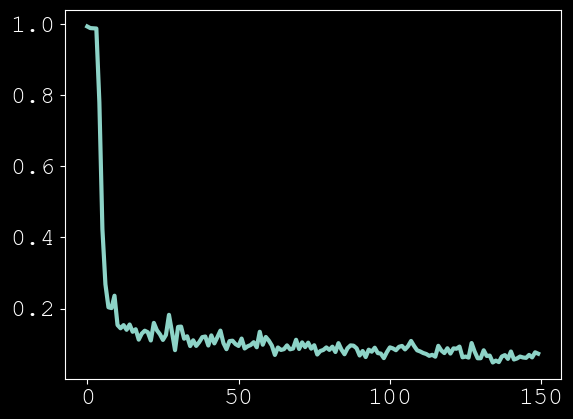

In [8]:
plt.plot(Loss[10:])

In [9]:
def plot_compare(test_id):
    cond_s = cond[test_id*28:(test_id+1)*28]
    cond_PV_base = PV_base[test_id*28:(test_id+1)*28]
    x_seq = ddpm.sample_seq(batch_size=28, cond=cond_s, PV_base = cond_PV_base)

    x_seq = x_seq.to("cpu")

    test_data = dataset[test_id*28:(test_id+1)*28].to('cpu')
    plt.figure(figsize=(15,3), dpi=300)
    plt.subplot(1,4,1)
    for i in range(len(test_data)):
        plt.plot(test_data[i])
    plt.title("actual data")
    plt.subplot(1,4,2)
    for i in range(len(x_seq[-1])):
        plt.plot(x_seq[-1][i])
    plt.title("generated data")
    plt.subplot(1,4,3)
    plt.plot(x_seq[-1].mean(dim=0), label = "mean of generated data")
    plt.plot(test_data.mean(dim=0), label = "mean of actual data")
    plt.legend(fontsize=10)
    plt.subplot(1,4,4)
    plt.plot(x_seq[-1].var(dim=0), label = "variance of generated data")
    plt.plot(test_data.var(dim=0), label = "variance of actual data")
    plt.legend(fontsize=10)
    plt.tight_layout()

/home/npg5/anaconda3/envs/hnn/lib/python3.8/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


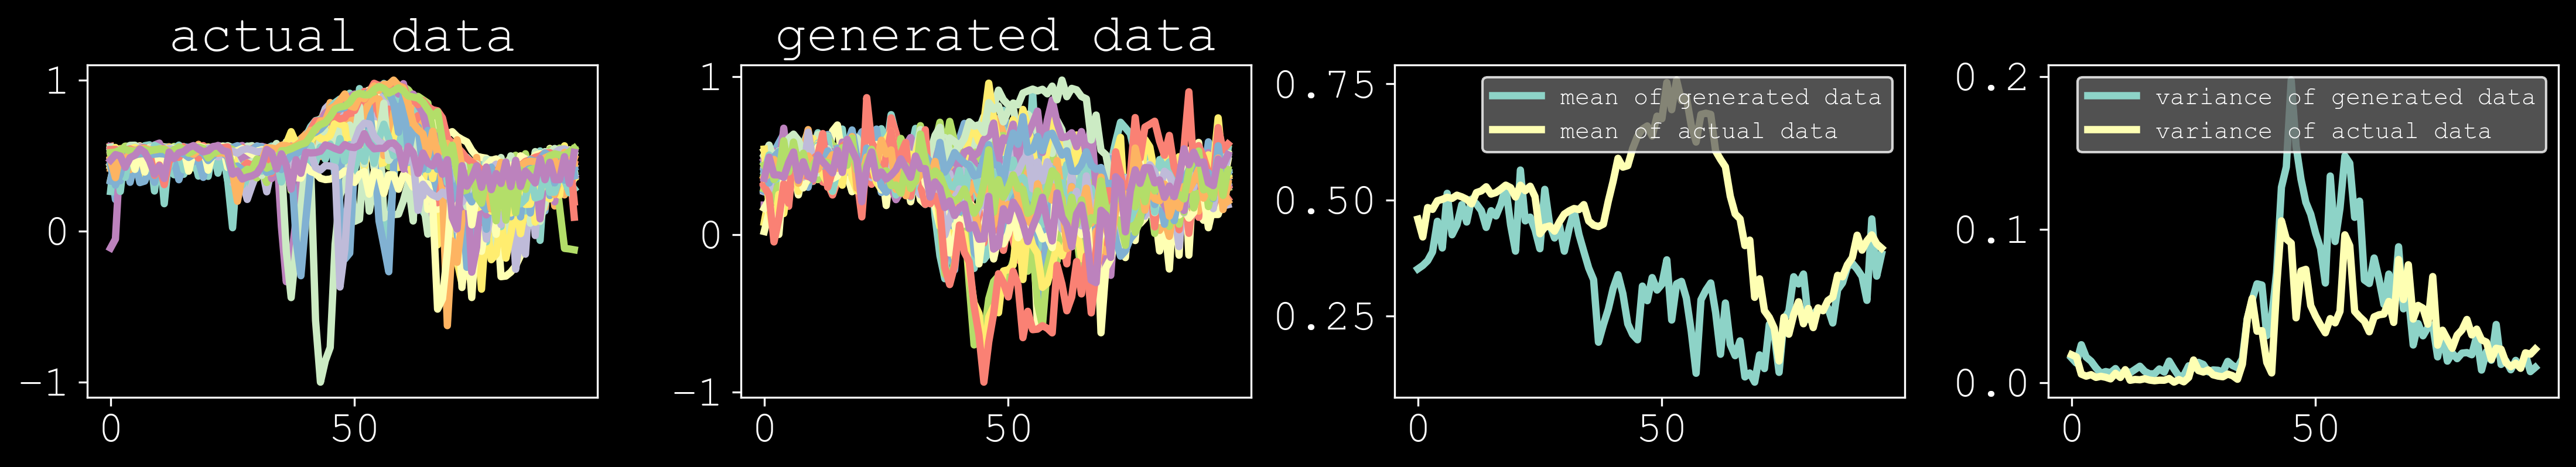

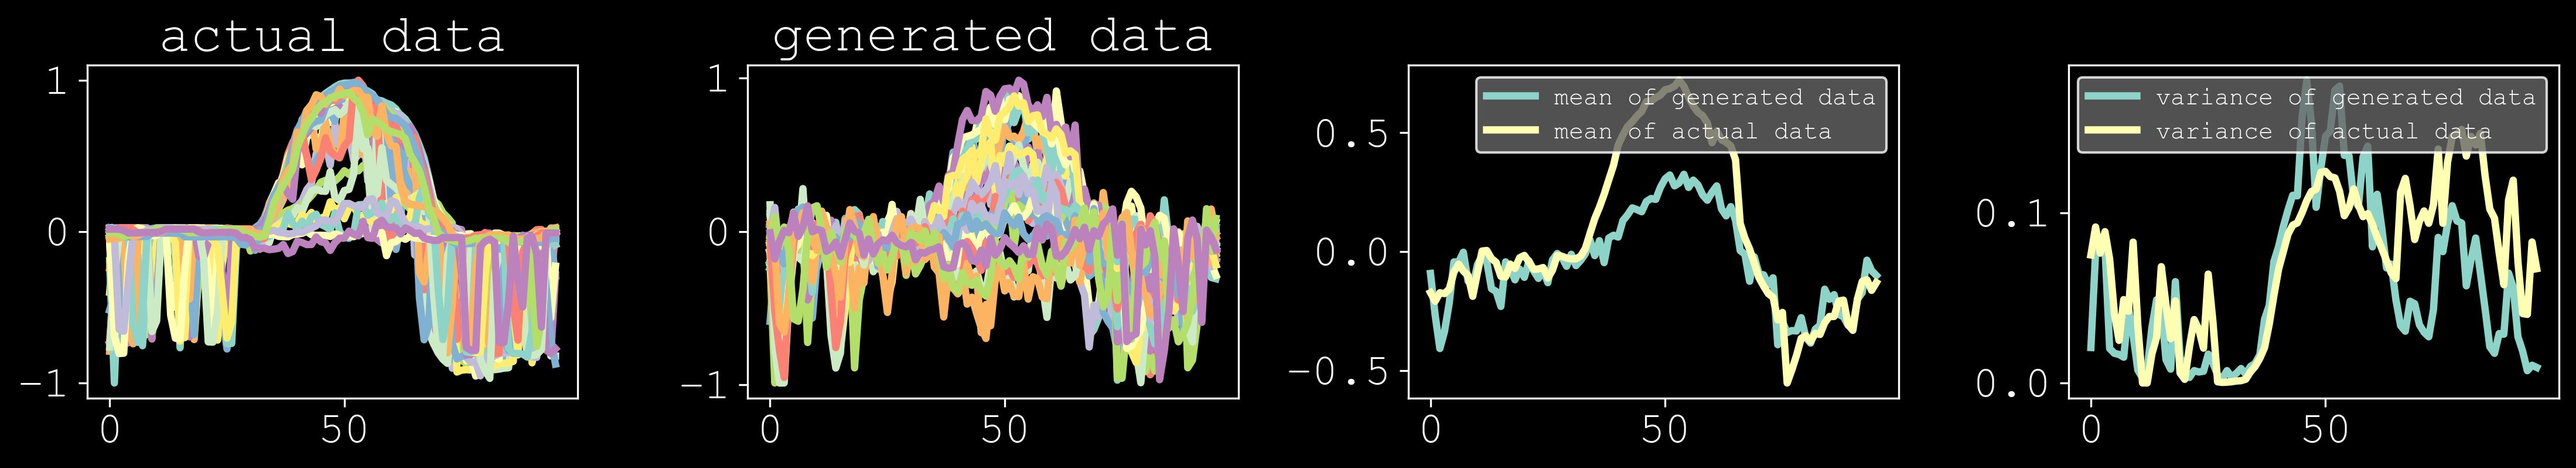

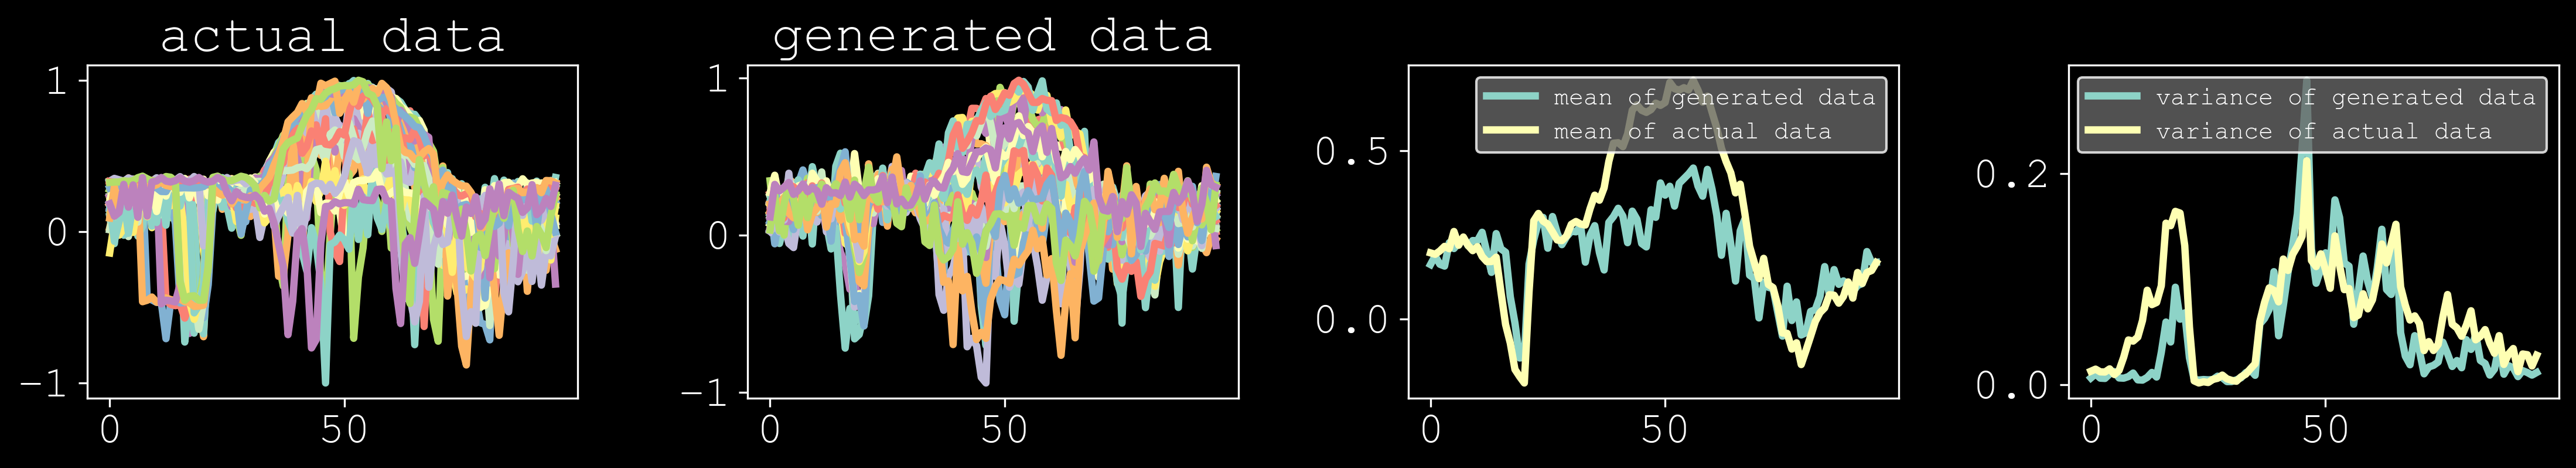

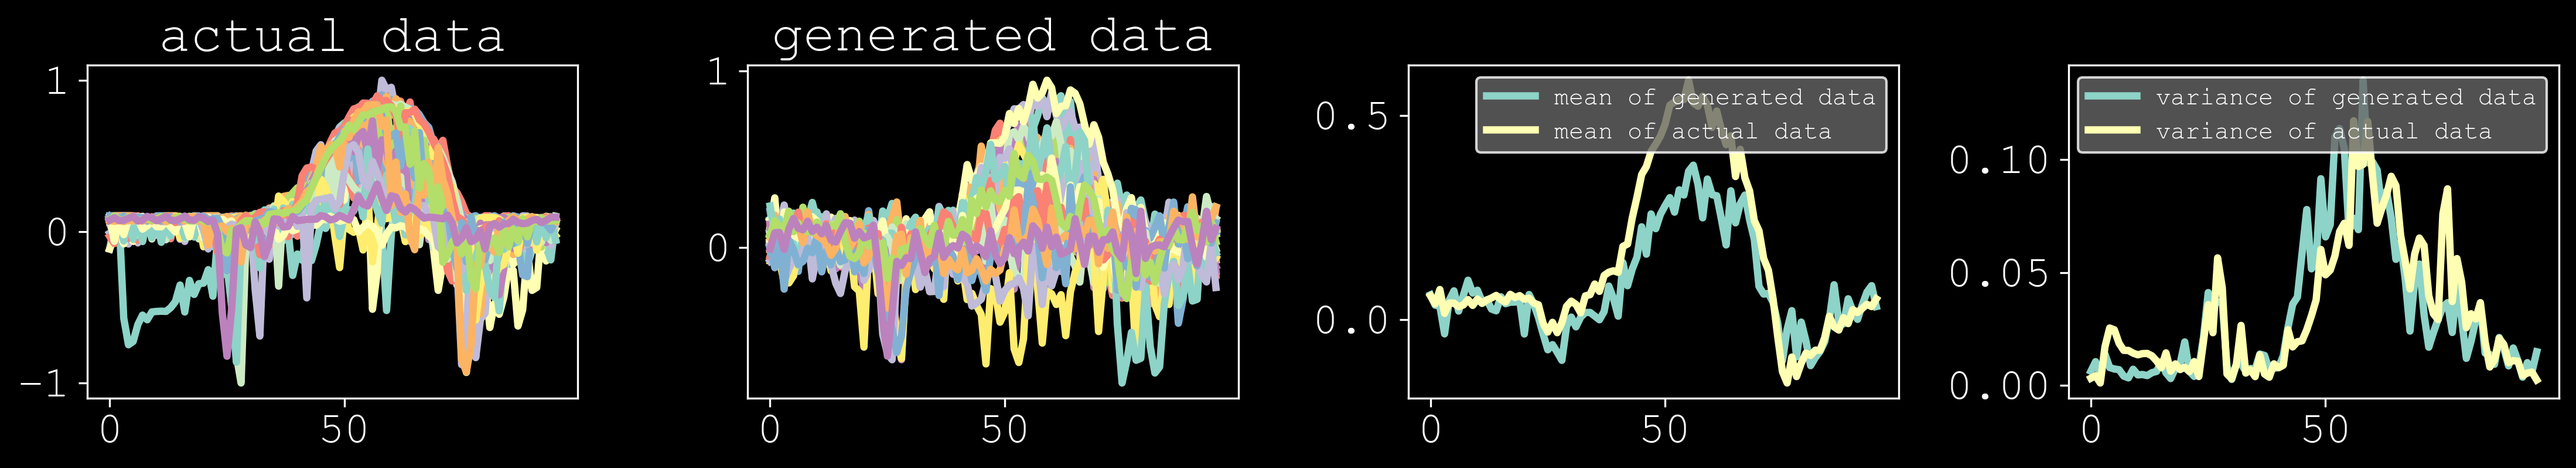

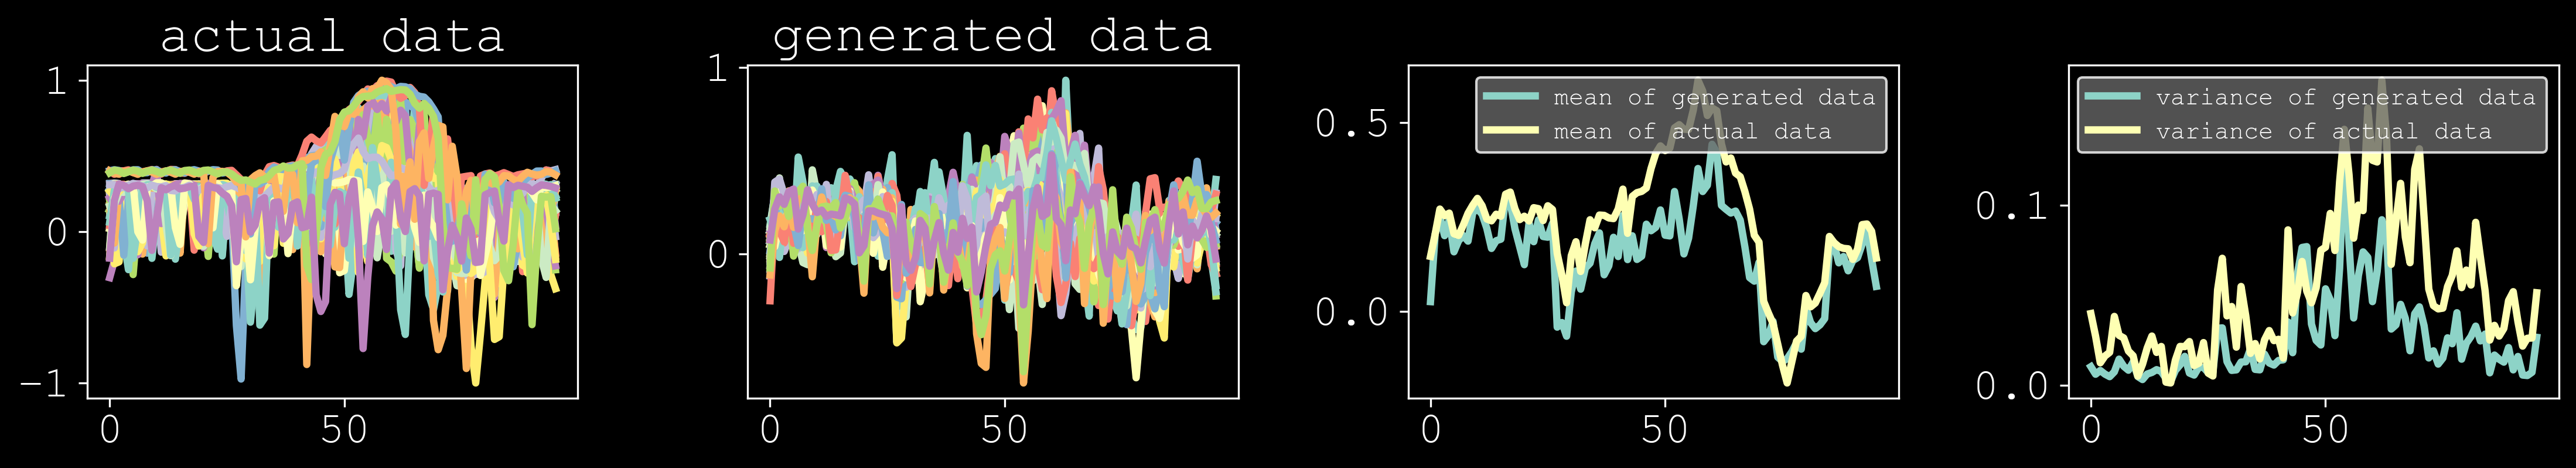

In [10]:
for i in range(5):
    plot_compare(i)
